In [1]:
library(enrichplot)
library(DOSE)
library(tidyr)
library(clusterProfiler)
library(ggplot2)
library(patchwork)
source('/home/hsarkar/Workplace/slide-seq-de/R/spatial_util.R')
source('/home/hsarkar/Workplace/slide-seq-de/R/function.GO.R')
source('/home/hsarkar/Workplace/slide-seq-de/R/linear_model.R')
source('/home/hsarkar/Workplace/slide-seq-de/R/stan_helper.R')



Registered S3 method overwritten by 'ggtree':
  method      from 
  identify.gg ggfun

DOSE v3.18.3  For help: https://guangchuangyu.github.io/software/DOSE

If you use DOSE in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Guang-Rong Yan, Qing-Yu He. DOSE: an R/Bioconductor package for Disease Ontology Semantic and Enrichment analysis. Bioinformatics 2015, 31(4):608-609


clusterProfiler v4.1.4  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter



Attaching package: ‘ggrastr’


The following object is masked from ‘package:raster’:

    rasterize



Attaching package: ‘pheatmap

In [32]:
fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

In [2]:
cdl <- readRDS(
    '/home/hsarkar/Workplace/slide-seq-de/data/processed/raw.objects_all.rds'
)
cdl.p2 <- readRDS(
    '/home/hsarkar/Workplace/slide-seq-de/data/processed/pagoda_all.rds'
)

angiogenesis.genes <- readLines(con <- file(
    "/home/hsarkar/Workplace/slide-seq-de/data/de_results/angiogenesis.list"))

emt.genes <- readLines(con <- file(
    "/home/hsarkar/Workplace/slide-seq-de/data/de_results/emt.list"))

lr.pairs = read.csv('/d0/home/meisl/Workplace/Prostate/healty.data/conos/F7.slide.seq/all.sig.csv')
lr.genes = unique(union(lr.pairs$receptor , lr.pairs$ligand))


extra.genes <- union(angiogenesis.genes, emt.genes)
extra.genes <- union(extra.genes, lr.genes)

marker.de <- lapply(cdl.p2[c('Tumor01','Tumor02')], function(p2){
    p2$getDifferentialGenes(
    type="PCA",clusterType="annot",verbose=TRUE,append.auc=TRUE, upregulated.only=TRUE)
})
tumor.markers.01 <- marker.de[['Tumor01']][['Tumor']] %>% arrange(-AUC) %>% rownames
tumor.markers.02 <- marker.de[['Tumor02']][['Tumor']] %>% arrange(-AUC) %>% rownames

target_ctypes = c(
    'Endothelial cells-2',
    'Pericytes-2',
    'Fibroblasts',
    'Epithelial_Hillock',
    'Epithelial_Club',
    'Macrophage'   
)

running differential expression with 13 clusters ... 

adjusting p-values ... 

done.


running differential expression with 13 clusters ... 

adjusting p-values ... 

done.




In [6]:
source('/home/hsarkar/Workplace/slide-seq-de/R/function.GO.R')
my_pathways = get.msigdb.pathways()
msig_dbs = readRDS('../data/msig_db.rds')

In [7]:
source('/home/hsarkar/Workplace/slide-seq-de/R/spatial_util.R')
source('/home/hsarkar/Workplace/slide-seq-de/R/linear_model.R')
run.de.for.subset.ctypes = function(
  distance,
  correct.pvals=FALSE,
  n.top.genes = 300,
  top.genes = 10
){
  profiles.list = list()
  puck.profiles = lapply(c('Tumor01','Tumor02'),function(puck.name){
    t1 <- cdl.p2[[puck.name]]
    t1.raw <- cdl[[puck.name]]
    
    if(puck.name == "Tumor01"){
      nontumor.center = c(2000, 2500)
      tumor.center = c(4250, 3250)
    }else{
      tumor.center <- c(2500, 2700)
      nontumor.center <- c(4250, 3250)
    }
    
    prepare.rprofile(
        t1,
        t1.raw,
        distance, 
        tumor.center,
        nontumor.center,
        extra.genes
    )
  })
  names(puck.profiles) = c('Tumor01','Tumor02')
  
  profiles.list[[1]] = puck.profiles[['Tumor01']]$rprofile
  profiles.list[[2]] = puck.profiles[['Tumor02']]$rprofile
  
  ## All cell-types
  multi.de.res =  lapply(target_ctypes, function(target){
        print(target)
        target1 = paste(target, 'Tumor', sep='_')
        target2 = paste(target, 'Non_Tumor', sep='_')
        de.res = lmcdde(profiles.list, target1, target2,
                                 method = 'bvls',
                                 de.method = 'edgeR.lrt')
        if(is.null(de.res)){
          return(NULL)
        }
        de.plot = ggplot.scatter.plot(de.res, intersect(tumor.markers.01,
                                                        tumor.markers.02)[1:50],
                                                       target,20)

        et= de.res$tt
        et$Z = -qnorm(pmin(et$PValue, 0.5)) * sign(et$logFC)
        et = as.data.frame(et)
        
        get.gns.per.ctype <- function(de, Z=TRUE, n.top.genes =300 ){
          if(Z){
            gns <- list(
                    up= de %>% filter(Z > 0) %>% arrange(-Z) %>% rownames %>% head(n.top.genes) ,
                    down = de %>% filter(Z < 0) %>% arrange(Z) %>% rownames %>% head(n.top.genes) ,
                    all= rownames(de)
                    )
          }else{
            gns <- list(
                    up= de %>% filter(logFC > 0) %>% arrange(-logFC) %>% rownames %>% head(n.top.genes) ,
                    down = de %>% filter(logFC < 0) %>% arrange(logFC) %>% rownames %>% head(n.top.genes) ,
                    all= rownames(de)
                    )
          }
          gns
        }
        
        gns = get.gns.per.ctype(et, Z=FALSE)
        pvals = lapply(gns[c('up','down')], function(x){
          get.gsea.pvals(x, gns$all, my_pathways, correct.pvals = correct.pvals)
        })
        
        pvals.filtered <- lapply(pvals, function(y){
            y %>% data.frame %>%
            magrittr::set_colnames(c('pval')) %>%
            arrange(pval) %>% 
            filter(pval < 0.05)
        })
        pvals.filtered$term = rownames(pvals.filtered)
        # rownames(pvals.filtered) = 1:nrow(pvals.filtered)
        list(de.res = de.res, 
             scatter.plot = de.plot,
             pvals = pvals.filtered
             )
      }
  )
  names(multi.de.res) = target_ctypes
  multi.de.res <- multi.de.res[!sapply(multi.de.res,is.null)]
  list(
    multi.de = multi.de.res,
    subset = puck.profiles,
    dist = distance
  )
}

In [8]:
dist.de = run.de.for.subset.ctypes(distance = 350, correct.pvals = FALSE)

[1] "Endothelial cells-2"
[1] "Pericytes-2"
[1] "Fibroblasts"
[1] "Epithelial_Hillock"
[1] "Epithelial_Club"
[1] "Macrophage"


In [9]:
profiles.list = list()
profiles.list[[1]] = dist.de$subset[['Tumor01']]$rprofile
profiles.list[[2]] = dist.de$subset[['Tumor02']]$rprofile

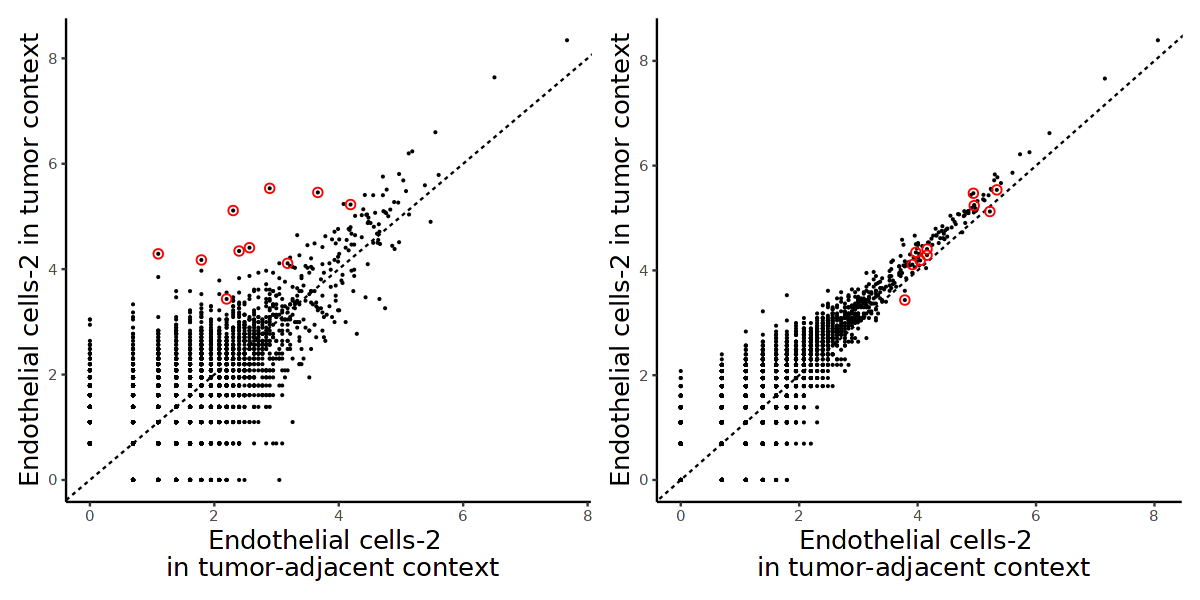

In [10]:
target = 'Endothelial cells-2'
target1 = paste(target, 'Tumor', sep='_')
target2 = paste(target, 'Non_Tumor', sep='_')

mats = get.corrected.uncorred.mat(
   profiles.list,
   target1,
   target2
)

df.mat = log(mats$mat[,1:2] + 1)   %>% data.frame %>% set_colnames(c('tumor_adjacent','tumor'))
df.mat.na = log(mats$mat.na[,1:2] +1)  %>% data.frame %>% set_colnames(c('tumor_adjacent','tumor'))

options(repr.plot.height=5, repr.plot.width=10, res=150 ) 

p1 = ggplot(df.mat.na, aes(x=tumor_adjacent, y=tumor)) +
    geom_point(size=0.1) +
    #ggtitle('Before Correction') +
    geom_abline(slope = 1, intercept = 0, linetype="dashed") +
    xlab(paste(target,'\n in tumor-adjacent context')) + ylab(paste(target,'in tumor context')) +
    #geom_point(data=df.mat.na[up.genes,],pch=21,fill=NA,size=2,colour='blue',stroke=0.6,aes(color='blue'))+
    geom_point(data=df.mat.na[tumor.markers.01[1:10],],pch=21,fill=NA,size=2,colour='red',stroke=0.6,aes(color='red')) +
    theme_classic() + theme(plot.title = element_text(size = 8),axis.title=element_text(size=15))

p2 = ggplot(df.mat, aes(x=tumor_adjacent, y=tumor)) +
    geom_point(size=0.1) +
    #ggtitle('After Correction') +
    geom_abline(slope = 1, intercept = 0, linetype="dashed") +
    xlab(paste(target,'\n in tumor-adjacent context')) + ylab(paste(target,'in tumor context')) +
    #geom_point(data=df.mat[up.genes,],pch=21,fill=NA,size=2,colour='blue',stroke=0.6,aes(color='blue'))+
    geom_point(data=df.mat[tumor.markers.01[1:10],],pch=21,fill=NA,size=2,colour='red',stroke=0.6,aes(color='red')) +
    theme_classic() + theme(plot.title = element_text(size = 8),axis.title=element_text(size=15))

p3 = p1 | p2
p3

In [11]:
save.image(file='figure_s4_b.RData')

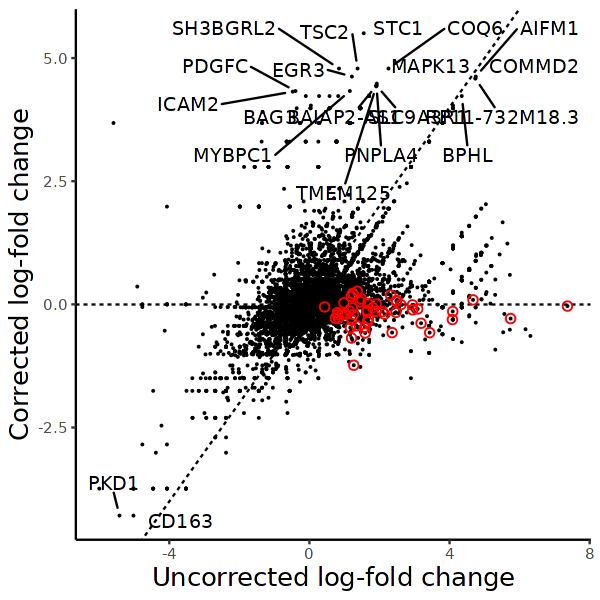

In [12]:
target = 'Endothelial cells-2'
res = dist.de$multi.de[[target]]$de.res
red.marker = intersect(tumor.markers.01, tumor.markers.02)[1:50]

top.genes=20

etuc <- res$tt.na; et <- res$tt
par(mfrow=c(1,2), mar=c(3.5,3.5,0.5,0.5),mgp=c(2,0.65,0),
oma=c(0,0,2,0))
sdf <- data.frame(uc=etuc$logFC,c=et$logFC); rownames(sdf) <- rownames(et)
genes <- sdf[order(-abs(sdf$c))[1:top.genes],] %>% rownames

options(repr.plot.height=5, repr.plot.width=5, res=150 ) 
p1 <- ggplot(sdf, aes(x=uc,y=c)) + 
    geom_point(size=0.05) +
    geom_hline(yintercept=0,linetype="dashed")+
    labs(x='Uncorrected log-fold change', y='Corrected log-fold change') + 
    geom_abline(slope = 1, intercept = 0, linetype="dashed") +
    geom_point(data=sdf[ red.marker ,],
                    pch=21, fill=NA, size=2, colour="red", stroke=0.6,na.rm=TRUE)+
    theme_classic() + 
    #ggtitle(target)+
    geom_text_repel( 
                data=sdf[ genes ,], # Filter data first
                aes(label = genes ),
                size = 4,
                box.padding = unit(0.5, "lines"),
                point.padding = unit(0.5, "lines"),
                max.overlaps = Inf,
                na.rm=TRUE
            ) + theme(plot.title = element_text(size = 8),axis.title=element_text(size=15))
p1

## Dotplot

In [13]:
objs = lapply( target_ctypes, function(cell.type){
    results = dist.de$multi.de[[cell.type]]$de.res$tt %>% 
        dplyr::arrange(logFC > 0) %>% dplyr::arrange(-logFC) %>% head(300) %>% rownames
    universe = dist.de$multi.de[[cell.type]] %>% rownames

    enricher(
        results[1:300], 
        universe = universe,
        TERM2GENE= msig_dbs$C5 %>% dplyr::select(gs_name, gene_symbol)
    )
})

names(objs) = target_ctypes

In [34]:
custom_default_labeller <- function(n) {
    function(str){
        str <- gsub("_", " ", str)
        str <- substr(str,6,nchar(str))
        str <- tolower(str)
        substr(str,1,1) = toupper(substr(str,1,1))
        yulab.utils::str_wrap(str, n)
    }
}
my.dotplot <- function(object, x = "geneRatio", color = "p.adjust",
                             showCategory=10, size=NULL, split = NULL,
                             font.size=12, title = "", orderBy="x",
                             label_format = 30, decreasing=TRUE) {

    colorBy <- match.arg(color, c("pvalue", "p.adjust", "qvalue"))
    if (x == "geneRatio" || x == "GeneRatio") {
        x <- "GeneRatio"
        if (is.null(size))
            size <- "Count"
    } else if (x == "count" || x == "Count") {
        x <- "Count"
        if (is.null(size))
            size <- "GeneRatio"
    } else if (is(x, "formula")) {
        x <- as.character(x)[2]
        if (is.null(size))
            size <- "Count"
    } else {
        ## message("invalid x, setting to 'GeneRatio' by default")
        ## x <- "GeneRatio"
        ## size <- "Count"
        if (is.null(size))
            size  <- "Count"
    }

    df <- fortify(object, showCategory = showCategory, split=split)
    
    ## already parsed in fortify
    ## df$GeneRatio <- parse_ratio(df$GeneRatio)

    if (orderBy !=  'x' && !orderBy %in% colnames(df)) {
        message('wrong orderBy parameter; set to default `orderBy = "x"`')
        orderBy <- "x"
    }

    if (orderBy == "x") {
        df <- dplyr::mutate(df, x = eval(parse(text=x)))
    }

    label_func <- custom_default_labeller(label_format)
    if(is.function(label_format)) {
        label_func <- label_format
    }

    idx <- order(df[[orderBy]], decreasing = decreasing)
    df$Description <- factor(df$Description,
                          levels=rev(unique(df$Description[idx])))
#     df <- df %>% 
#         mutate(Description = tolower(Description))
    ggplot(df, aes_string(x=x, y="Description", size=size, color=colorBy)) +
        geom_point() +
        scale_color_continuous(low="red", high="blue", name = color,
            guide=guide_colorbar(reverse=TRUE)) +
        scale_y_discrete(labels = label_func) +
        ylab(NULL) + ggtitle(title) + theme_dose(font.size) +
        scale_size(range=c(3, 8)) +
        guides(size  = guide_legend(order = 1), 
               color = guide_colorbar(order = 2))
}

In [37]:
fig.size(7,8)
plot.endo2 = my.dotplot(objs$`Endothelial cells-2`, showCategory = 10, font.size=17)

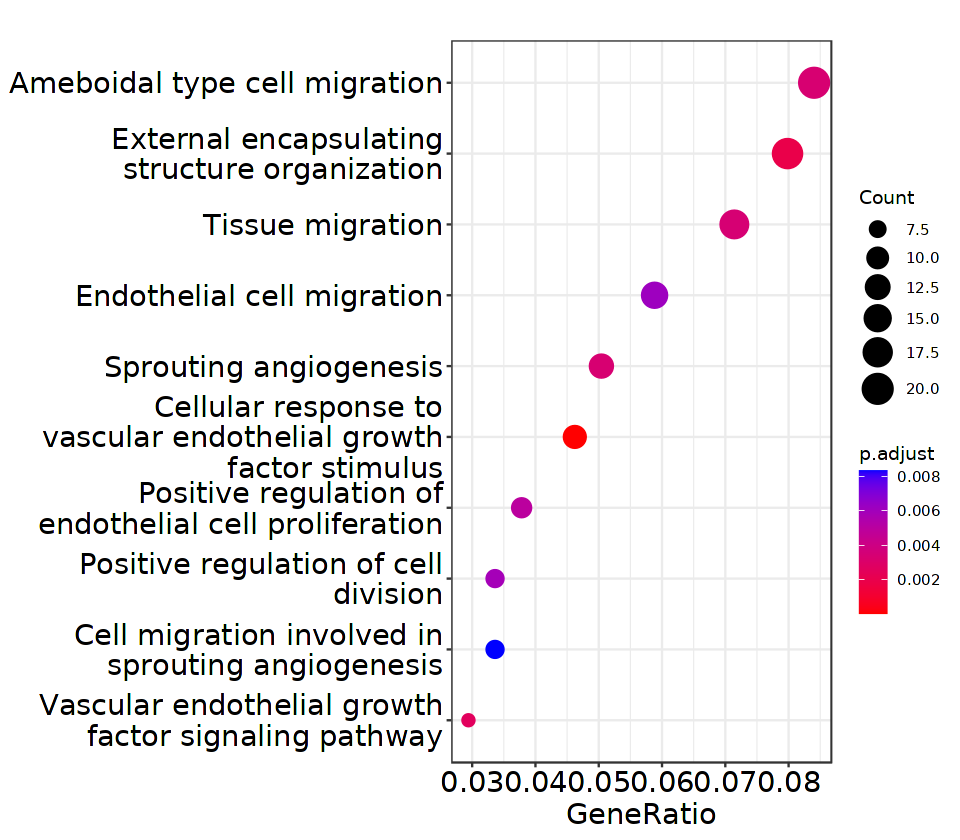

In [38]:
plot.endo2

In [39]:
list2df <- function(inputList) {
    # ldf <- lapply(1:length(inputList), function(i) {
    ldf <- lapply(seq_len(length(inputList)), function(i) {
        data.frame(categoryID=rep(names(inputList[i]),
                                  length(inputList[[i]])),
                   Gene=inputList[[i]])
    })

    do.call('rbind', ldf)
}

update_n <- function(x, showCategory) {
    if (!is.numeric(showCategory)) {
        if (inherits(x, 'list')) {
            showCategory <- showCategory[showCategory %in% names(x)]
        }
        return(showCategory)
    }

    ## geneSets <- geneInCategory(x) ## use core gene for gsea result
    n <- showCategory
    if (inherits(x, 'list')) {
        nn <- length(x)
    } else {
        nn <- nrow(x)
    }
    if (nn < n) {
        n <- nn
    }

    return(n)
}

extract_geneSets <- function(x, n) {
    n <- update_n(x, n)

    if (inherits(x, 'list')) {
        geneSets <- x
    } else {
        geneSets <- geneInCategory(x) ## use core gene for gsea result
        y <- as.data.frame(x)
        geneSets <- geneSets[y$ID]
        names(geneSets) <- y$Description        
    }
    if (is.numeric(n)) {
        return(geneSets[1:n])
    }
    return(geneSets[n]) ## if n is a vector of Description
}

fc_readable <- function(x, foldChange = NULL) {
    if (is.null(foldChange))
        return(NULL)

    if(x@readable) {
        gid <- names(foldChange)
        if (is(x, 'gseaResult')) {
            ii <- gid %in% names(x@geneList)
        } else {
            ii <- gid %in% x@gene
        }
        gid[ii] <- x@gene2Symbol[gid[ii]]
        names(foldChange) <- gid
    }
    return(foldChange)
}

my.heatplot <- function(x, showCategory=30, foldChange=NULL,
                                  label_format = 30) {

    label_func <- custom_default_labeller(label_format)
    if(is.function(label_format)) {
        label_func <- label_format
    }

    n <- update_n(x, showCategory)
    geneSets <- extract_geneSets(x, n)

    foldChange <- fc_readable(x, foldChange)
    d <- list2df(geneSets)

    if (!is.null(foldChange)) {
        d$foldChange <- foldChange[as.character(d[,2])]
        ## palette <- fc_palette(d$foldChange)
        p <- ggplot(d, aes_(~Gene, ~categoryID)) +
            geom_tile(aes_(fill = ~foldChange), color = "white") +
            scale_fill_continuous(low="white", high="red", name = "fold change")
        ## scale_fill_gradientn(name = "fold change", colors = palette)

    } else {
        p <- ggplot(d, aes_(~Gene, ~categoryID)) + geom_tile(color = 'white')
    }
    p + xlab(NULL) + ylab(NULL) + theme_minimal() +
        scale_y_discrete(labels = label_func) +
        theme(panel.grid.major = element_blank(),
              axis.text.x=element_text(angle = 60, hjust = 1))
}

In [40]:
cell.type = 'Endothelial cells-2'
gene.list = dist.de$multi.de[[cell.type]]$de.res$tt %>% 
        dplyr::arrange(logFC > 0) %>% dplyr::arrange(-logFC) %>% head(300) %>% rownames
gene.list.lfc = dist.de$multi.de[[cell.type]]$de.res$tt[gene.list,'logFC']
names(gene.list.lfc) = gene.list
options(repr.plot.height=6, repr.plot.width=16, res=150 ) 
h.endo = my.heatplot( objs[[cell.type]] , 
                     foldChange=gene.list.lfc, showCategory=10
                    ) +  theme(axis.text.x = element_text(size=10),axis.text.y = element_text(size=10))


Warning message:
“`aes_()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


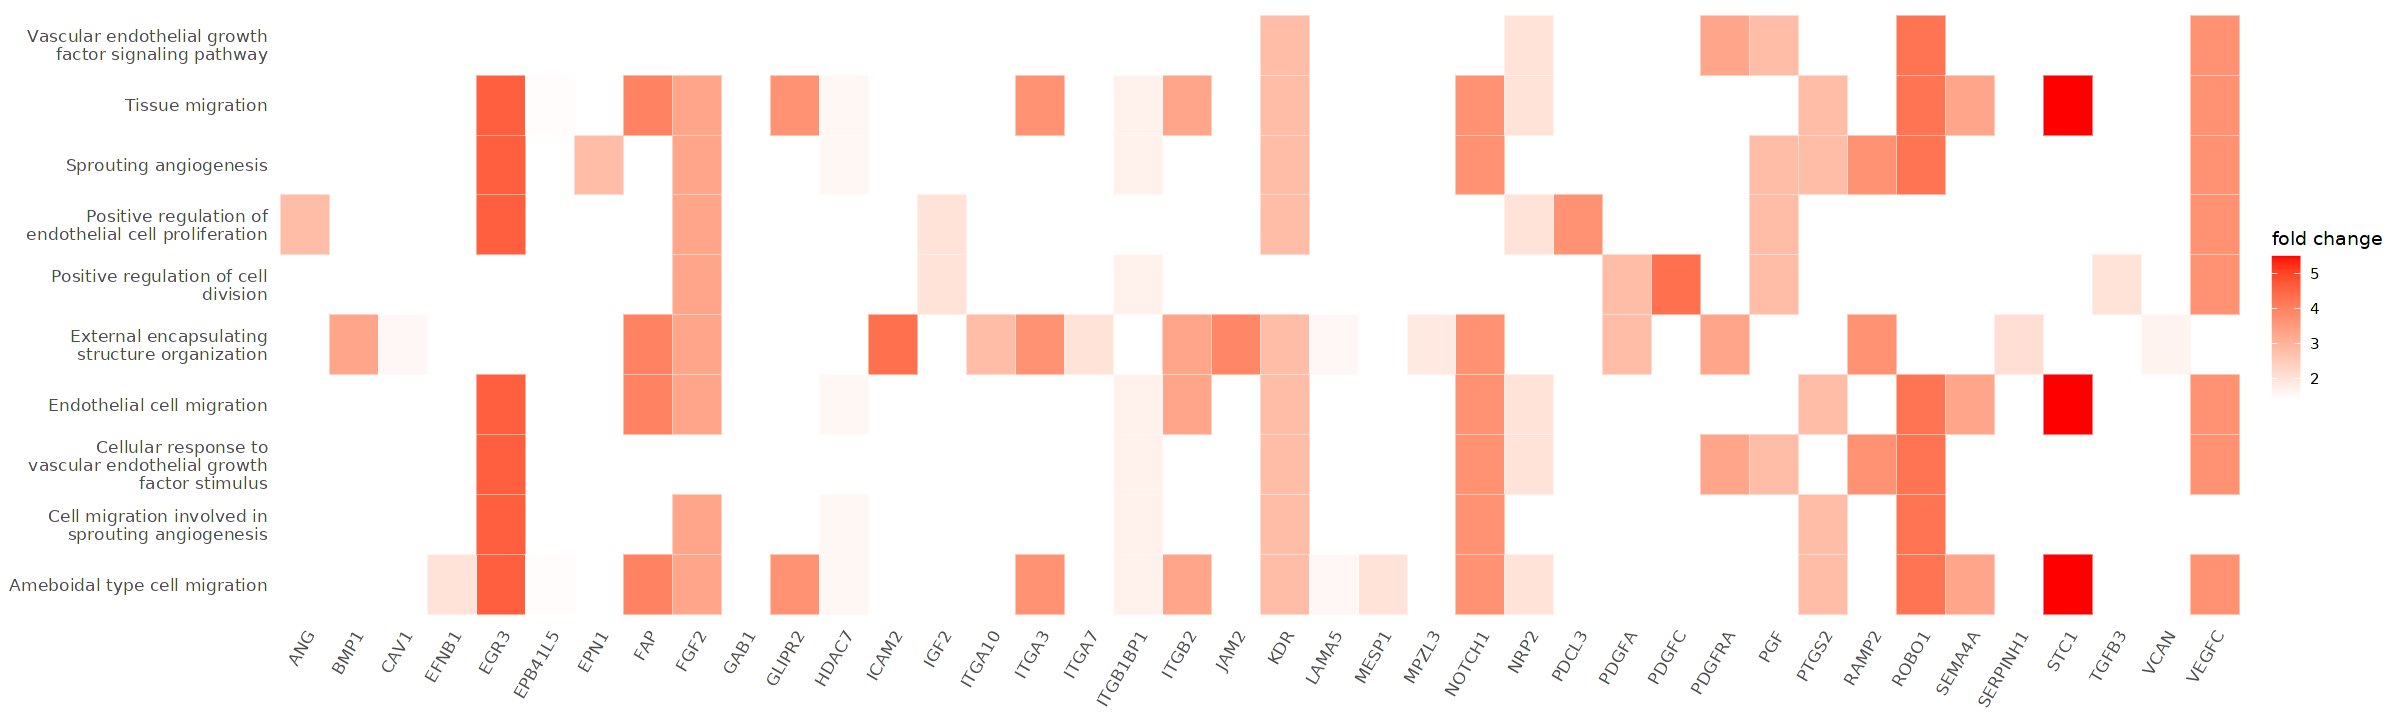

In [41]:
fig.size(6,20)
h.endo

In [42]:
cell.type = 'Fibroblasts'
gene.list = dist.de$multi.de[[cell.type]]$de.res$tt %>% 
        dplyr::arrange(logFC > 0) %>% dplyr::arrange(-logFC) %>% head(300) %>% rownames
gene.list.lfc = dist.de$multi.de[[cell.type]]$de.res$tt[gene.list,'logFC']
names(gene.list.lfc) = gene.list
options(repr.plot.height=6, repr.plot.width=20, res=150 ) 
h.fibro = my.heatplot( objs[[cell.type]] , foldChange=gene.list.lfc, showCategory=10) +  theme(axis.text.x = element_text(size=10),axis.text.y = element_text(size=10))

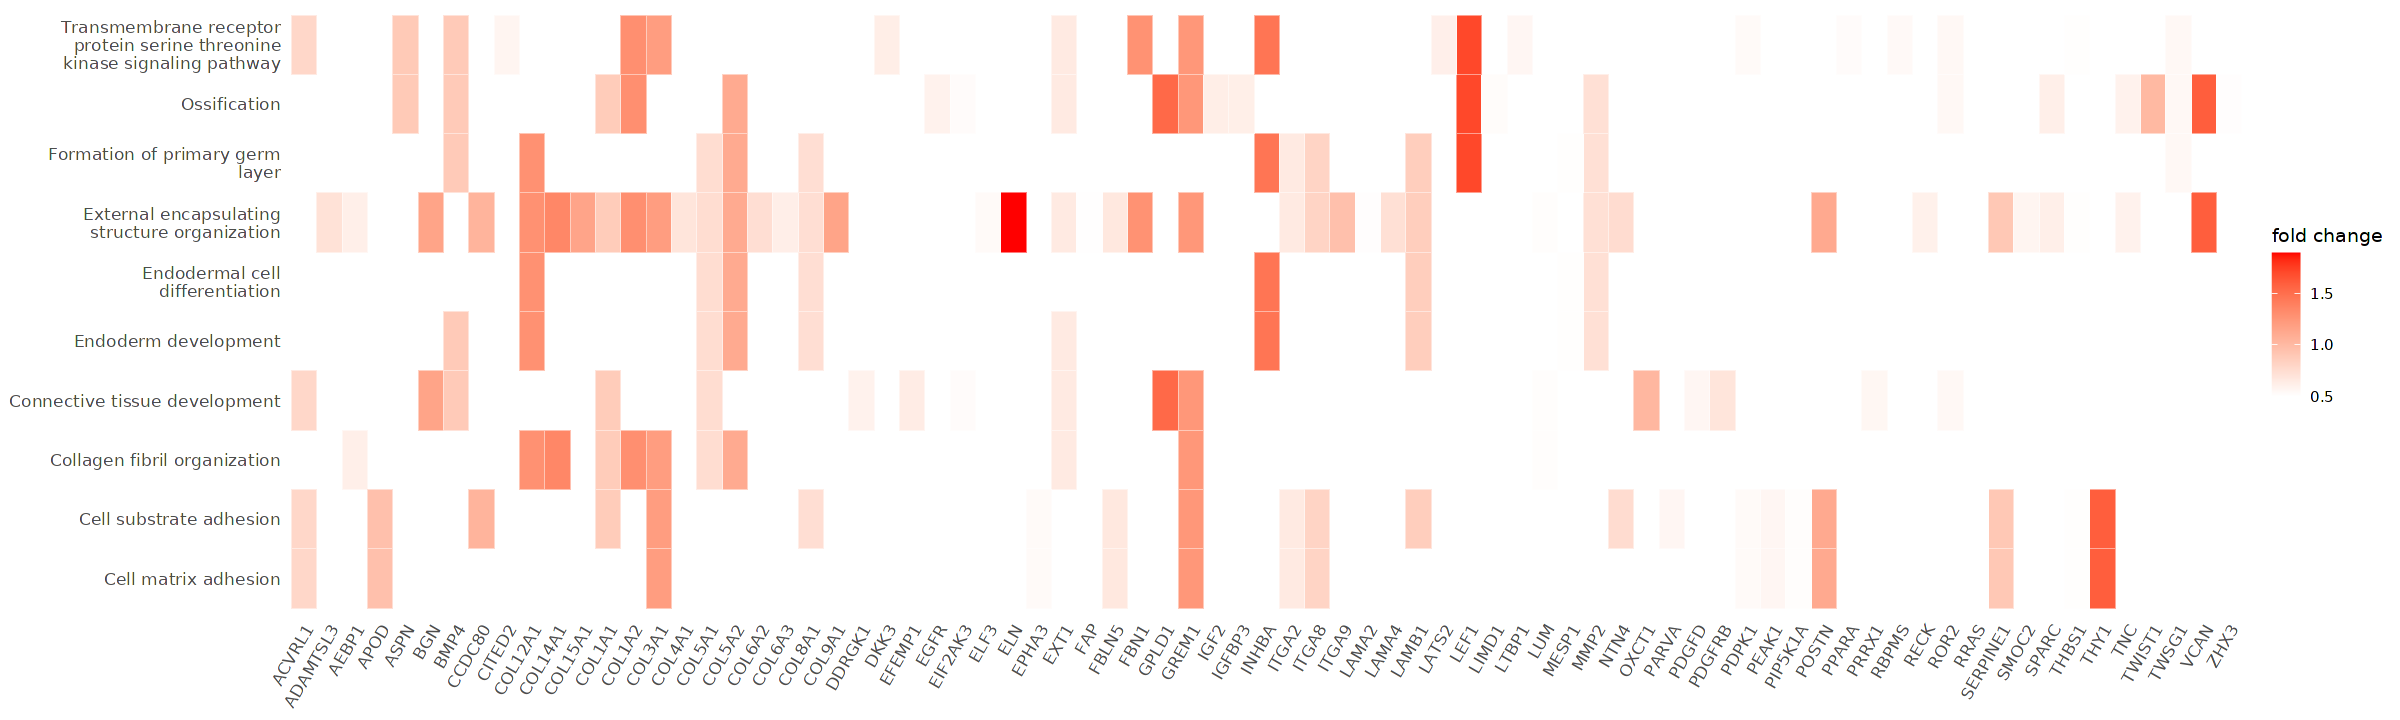

In [43]:
fig.size(6,20)
h.fibro

In [ ]:
save.image('/home/meisl/Workplace/Prostate/healty.data/conos/Figures.v2/F7.slide.seq/DE/Figure_3_D_E_S4_B_C_D.RData')